In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [19]:
df = pd.read_csv(f'../data/ATVI/2021-06-01 - 2021-09-01.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,time,price
0,2021-06-01 04:00:00+00:00,97.41
1,2021-06-01 04:15:00+00:00,97.76
2,2021-06-01 04:30:00+00:00,97.99
3,2021-06-01 04:45:00+00:00,97.97
4,2021-06-01 05:00:00+00:00,97.80


In [20]:
test_size = 74
train_df = df[:-test_size]
test_df = df[-test_size:]

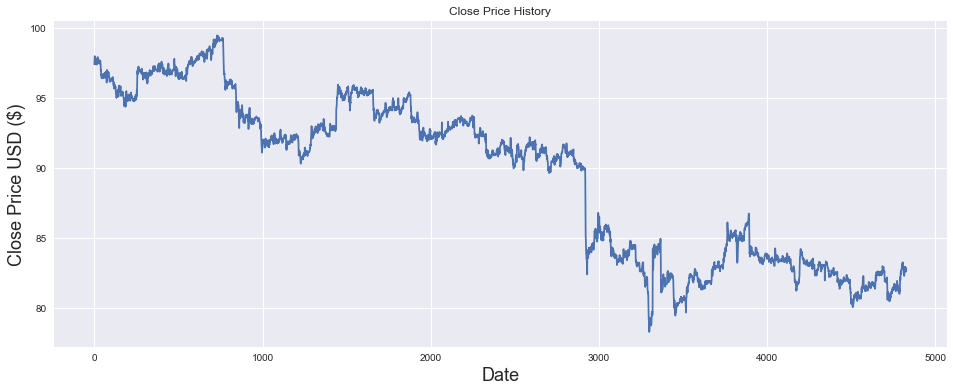

In [23]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [41]:
data = df.filter(['price'])
dataset = data.values

training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len
type(dataset)

numpy.ndarray

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.90269249],
       [0.91922532],
       [0.93008975],
       ...,
       [0.20925838],
       [0.20311762],
       [0.20547945]])

In [43]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(test_size, len(train_data)):
    x_train.append(train_data[i-test_size: i, 0])
    y_train.append(train_data[i, 0])
    if i <= test_size + 1:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.90269249, 0.91922532, 0.93008975, 0.92914502, 0.92111479,
       0.92205952, 0.91213982, 0.92064242, 0.91072272, 0.90316486,
       0.92158715, 0.90741615, 0.90174776, 0.91072272, 0.91166745,
       0.91166745, 0.91072272, 0.90410959, 0.91119509, 0.92678318,
       0.92631082, 0.91402929, 0.92064242, 0.91402929, 0.91213982,
       0.91686349, 0.91686349, 0.91213982, 0.90694379, 0.91544639,
       0.90552669, 0.91213982, 0.90505432, 0.90883325, 0.90930562,
       0.91544639, 0.90694379, 0.90410959, 0.88143599, 0.88521493,
       0.8644308 , 0.8658479 , 0.85829003, 0.85545583, 0.85687293,
       0.86065187, 0.85687293, 0.8615966 , 0.86820973, 0.86915446,
       0.86820973, 0.8615966 , 0.8559282 , 0.8559282 , 0.8615966 ,
       0.86537553, 0.867265  , 0.86820973, 0.87104393, 0.86820973,
       0.87340576, 0.8686821 , 0.85970713, 0.85687293, 0.8615966 ,
       0.87340576, 0.87623996, 0.8601795 , 0.87623996, 0.87529523,
       0.87482286, 0.87482286, 0.87671233, 0.84128484])]
[0.8

In [44]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
%%time

model.fit(x_train, y_train, batch_size=1, epochs=1)

4512/4512 [==============================] - 68s 15ms/step - loss: 9.8401e-04

In [46]:
test_data = scaled_data[training_data_len - test_size: , :]

x_test = []
y_test = dataset[training_data_len: , :]

for i in range(test_size, len(test_data)):
    x_test.append(test_data[i-test_size: i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

0.35839535004485956

In [49]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predicted'] = predictions
valid

C:\Users\spark\AppData\Local\Temp/ipykernel_9580/2121949022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = predictions


,price,Predicted
4586,81.57,81.666969
4587,81.64,81.765617
4588,81.58,81.871529
4589,81.59,81.926674
4590,81.43,81.946411
...,...,...
4822,82.72,83.203018
4823,82.93,83.168152
4824,82.73,83.183151
4825,82.60,83.142265


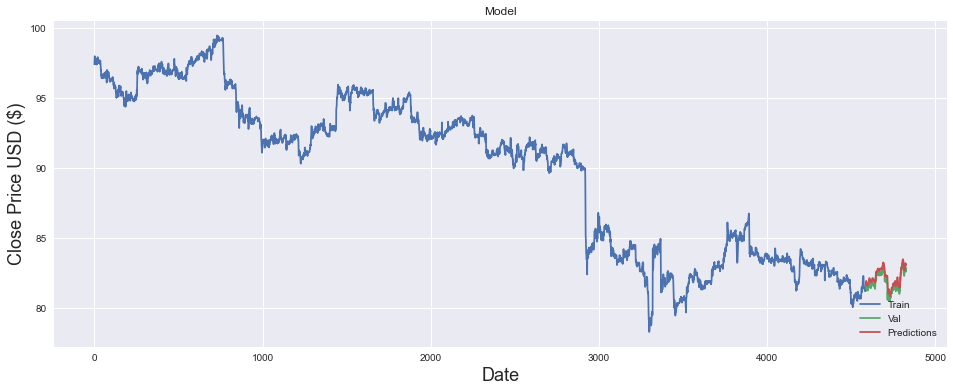

In [50]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price'])
plt.plot(valid[['price', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [51]:
train = train[4000:]

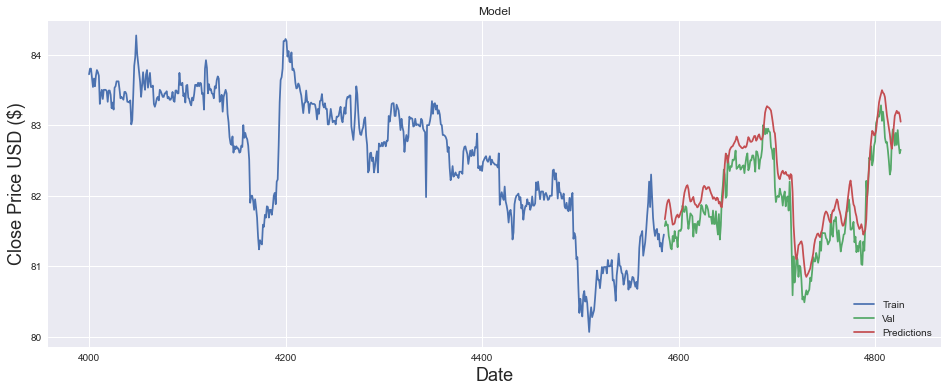

In [52]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price'])
plt.plot(valid[['price', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()